In [1]:
import numpy as np
from typing import List

import torch
import quairkit as qkit
from quairkit import to_state
from quairkit.database import *
from quairkit.qinfo import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 18

In [4]:
qkit.set_dtype('complex128')
revise_tol(1e-40)

Since this part involve random measurements, we fix one seed to reproduce our plot data. One can uncomment this line to obtain a different but similar result.

In [5]:
# qkit.set_seed(np.random.randint(1e7))
qkit.set_seed(20250828)
qkit.get_seed()

20250828

## Experiment setting

prepare Hamiltonian

In [6]:
num_qubits = 5

H_init = afm_heisenberg(n=num_qubits)
H = normalize(H_init, factor=np.abs(H_init.coefficients).sum())  # normalize the Hamiltonian

In [7]:
eigvals, eigvecs = torch.linalg.eigh(H.matrix)

ground_state_energy = eigvals[0].item()
ground_state = to_state(eigvecs[:, 0])

print(f'ground state energy = {ground_state_energy}')

ground state energy = -0.7319715633294984


Prepare input state as the computational state with the smallest non-zero overlap with the ground state

In [8]:
small_index = torch.argmin(torch.where(torch.abs(eigvecs[:, 0]) > 1e-10, torch.abs(eigvecs[:, 0]), 1)).item()
phi_state = computational_state(index=small_index, system_dim=2 ** num_qubits)

gamma = torch.abs(phi_state.bra @ ground_state.ket).item()
print(f'The state overlap between input state and ground state is {gamma}')

The state overlap between input state and ground state is 0.04798860730154218


Prepare evolution operator

In [9]:
U = torch.matrix_exp(-1j * H.matrix)

Define the convergence criteria of the sequence of ground-state energy estimation.

In [ ]:
def converge_test(list_data: List[float], list_err: List[float]) -> bool:
    r"""Test for convergence
    
    Args:
        list_data: a list of estimation data
        list_err: a list of estimation error given by their 95% confidence interval, corresponding to each estimation
    
    Returns:
        a boolean determines whether the estimation sequence converges or not
    
    """
    assert len(list_data) == len(list_err)

    if len(list_data) <= 2:
        return False
    
    return abs(list_data[-1] - list_data[-2]) <= list_err[-1]

## Compute data

In [11]:
tau = 3
deg = 322
B = 1 / 5000
delta_tau = 2

In [12]:
guess_lambda = algorithm6(tau, H, phi_state, deg, B)

list_ground_tau, list_E_tau, list_error, list_resource = algorithm1(tau, H, phi_state, guess_lambda, delta_tau, converge_test)

Computations of angles for QPP are completed with mean error 0.0006711045575487903
Computations of angles for QPP are completed with mean error 0.01279313093214881
Computations of angles for QPP are completed with mean error 0.042091032245620275
Computations of angles for QPP are completed with mean error 0.014572920037994562
Computations of angles for QPP are completed with mean error 0.01879429847804247
Computations of angles for QPP are completed with mean error 0.017552777026282135
Computations of angles for QPP are completed with mean error 0.0038272689275123655
Computations of angles for QPP are completed with mean error 0.0034439105894133017
Computations of angles for QPP are completed with mean error 0.001426377229592943
Computations of angles for QPP are completed with mean error 0.0011740674373152582
Computations of angles for QPP are completed with mean error 0.002614990429459577
Computations of angles for QPP are completed with mean error 0.0019058561606591226
Computations 

## Plot

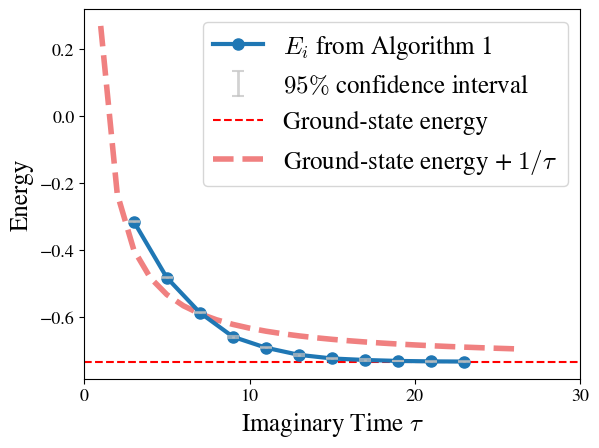

In [13]:
fontsize = 18

plt.plot(np.arange(1, 27), ground_state_energy + 1 / np.arange(1, 27), 
         '--', color= 'lightcoral', linewidth=4, label=r'Ground-state energy + $1/\tau$')

plt.axhline(y=ground_state_energy, color='r', linestyle='--', label=r'Ground-state energy')

plt.plot(list_ground_tau, list_E_tau, 
         'o-',                  # Circle markers + solid line
         color='C0',            # Main data color
         linewidth=3,           # Line width
         markersize=8,          # Marker size
         label=r'$E_i$ from Algorithm 1')       

plt.errorbar(list_ground_tau, list_E_tau, yerr=list_error, 
             fmt='none',         # No data markers/lines
             ecolor='silver',      # Error bar color
             elinewidth=2,       # Thicker error bars
             capsize=4,          # Cap size for error bars
             capthick=1.5,       # Thicker caps
             alpha=0.7,          # Slight transparency
             label=r'$95\%$ confidence interval')          

plt.xlabel(r'Imaginary Time $\tau$', fontsize=fontsize)
plt.ylabel(r'Energy', fontsize=fontsize)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,3,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', fontsize=fontsize)
plt.tick_params(labelsize=13)

plt.xticks([0, 10, 20, 30])
ticks = [-0.6, -0.66, -0.72]
# plt.yticks(ticks, [f'${tic:.2f}$' for tic in ticks])
plt.xlim(0, 30)

plt.show()

In [14]:
list_ground_error_log = np.log10(np.abs(np.array(list_E_tau) - ground_state_energy))

# 1. linear fit: y = a * x + b
coeffs = np.polyfit(list_resource, list_ground_error_log, 1)
poly_func = np.poly1d(coeffs)

# 2. generate x and y values
x_fit = np.linspace(min(list_resource), max(list_resource), 100)
y_fit = poly_func(x_fit)

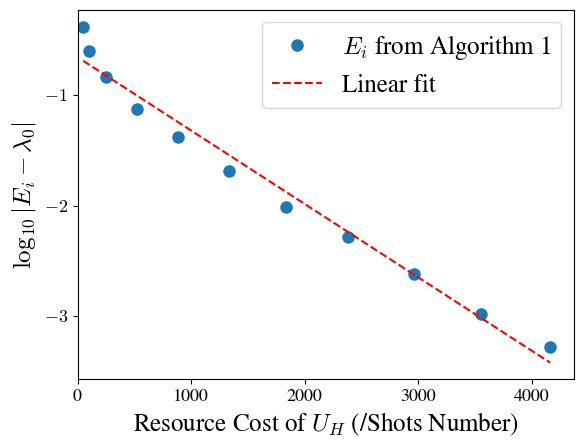

In [15]:
plt.plot(list_resource, list_ground_error_log, 'o', label=r'$E_i$ from Algorithm 1', markersize=8, color='C0')
plt.plot(x_fit, y_fit, '--', label='Linear fit', color='red')

plt.xlabel(r'Resource Cost of $U_H$ (/Shots Number)', fontsize=fontsize)
plt.ylabel(r'$\log_{10}|E_i - \lambda_0|$', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)

plt.xticks([0, 1000, 2000, 3000, 4000])
plt.xlim(0, None)
ticks = [-1, -2, -3]
plt.yticks(ticks, [f'${tic:.0f}$' for tic in ticks])
plt.tick_params(labelsize=13)

plt.show()

---

In [16]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.3
torch: 2.9.1+cu128
torch cuda: 12.8
numpy: 2.3.5
scipy: 1.16.3
matplotlib: 3.10.7
---------SYSTEM---------
Python version: 3.14.0
OS: Linux
OS version: #88-Ubuntu SMP PREEMPT_DYNAMIC Sat Oct 11 09:28:41 UTC 2025
---------DEVICE---------
CPU:  AMD EPYC 9554 64-Core Processor
GPU: (0) NVIDIA GeForce RTX 3090
     (0) NVIDIA GeForce RTX 3090
